# Telco Customer Churn Prediction with AutoGluon

이 노트북은 AutoGluon을 사용하여 통신사 고객 이탈을 예측하는 모델을 만듭니다.

**순서**
1. 컬럼별로 데이터 분석 및 시각화
2. 전처리
3. 특성 엔지니어링
4. 모델링
5. 앙상블
6. 모델 비교 평가
7. submission.csv 파일 생성

| 분류 | 고객 인구통계 및 결제 (Demographics & Billing) | 분류 | 서비스 가입 정보 (Services & Contract) |
| :--- | :--- | :--- | :--- |
| **customerID** | 고객 식별 번호 (ID) | **tenure** | 고객의 가입 기간 (개월 수) |
| **gender** | 성별 (Female, Male) | **PhoneService** | 전화 서비스 사용 여부 |
| **SeniorCitizen** | 고령자 여부 (0:젊은층, 1:고령자) | **MultipleLines** | 다중 회선 사용 여부 |
| **Partner** | 배우자 유무 (Yes, No) | **InternetService** | 인터넷 서비스 제공업체 종류 |
| **Dependents** | 부양가족 유무 (Yes, No) | **OnlineSecurity** | 온라인 보안 서비스 유무 |
| **PaperlessBilling** | 전자청구서 사용 여부 (Yes, No) | **OnlineBackup** | 온라인 백업 서비스 유무 |
| **PaymentMethod** | 결제 방법 (카드, 이체, 수표 등) | **DeviceProtection** | 기기 보호 서비스 유무 |
| **MonthlyCharges** | 월간 요금 (Monthly) | **TechSupport** | 기술 지원 서비스 유무 |
| **TotalCharges** | 총 누적 요금 (수치형 변환 필요) | **StreamingTV** | 스트리밍 TV 이용 유무 |
| **Churn** | **고객 이탈 여부 (Target: Yes/No)** | **StreamingMovies** | 스트리밍 영화 이용 유무 |
| **Contract** | **계약 기간 (1개월/1년/2년)** | | |

In [1]:
df.columns

NameError: name 'df' is not defined

In [7]:
# 1. 라이브러리 임포트 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import os

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. 파일 존재 여부 먼저 확인
file_path = 'data/Telco-Customer-Churn.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ 데이터 로드 성공!")
    
    # 2. 'df'가 판다스 데이터프레임인지 확인
    if isinstance(df, pd.DataFrame):
        print("✅ df 변수가 데이터프레임으로 정상 선언되었습니다.")
        display(df.head())  # 이제 에러 없이 작동할 것입니다.
    else:
        print("❌ 변수 df가 데이터프레임이 아닙니다.")
else:
    print(f"❌ 에러: {file_path} 경로에 파일이 없습니다. 경로를 확인해주세요!")

✅ 데이터 로드 성공!
✅ df 변수가 데이터프레임으로 정상 선언되었습니다.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [9]:
# 데이터 전처리 전, TotalCharges의 빈 문자열 처리 필요
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

C:\Users\COM\AppData\Local\Temp\ipykernel_37260\1319828881.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


# 2. 컬럼별 데이터 분석 및 시각화 (EDA)
데이터의 분포와 이탈률(Churn)과의 관계를 살펴봅니다.

In [10]:
# Churn을 수치형으로 변환 (시각화를 위해)
df['Churn_Numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


C:\Users\COM\AppData\Local\Temp\ipykernel_37260\4195215460.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette=['#66b3ff','#fb8072'])


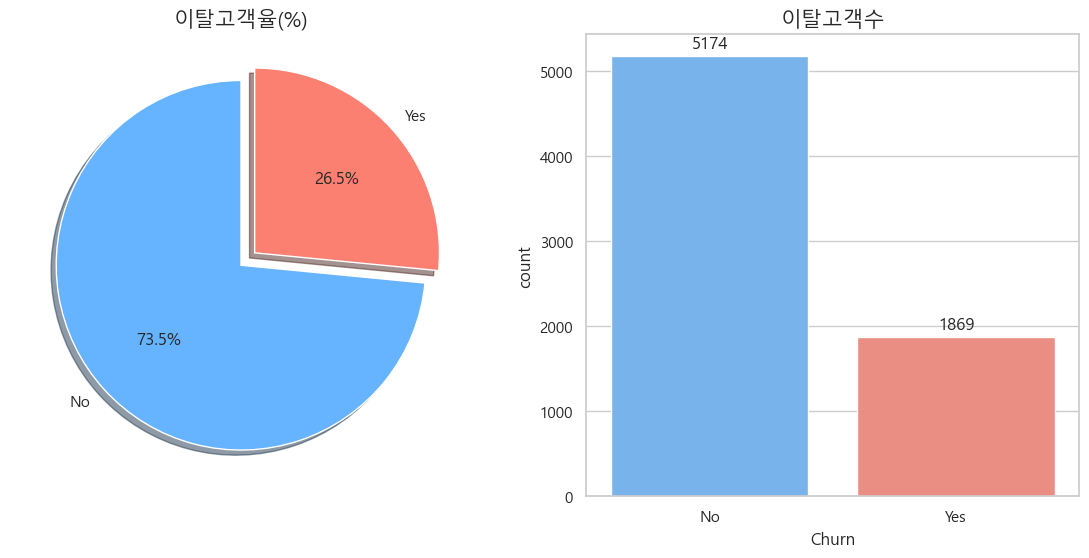

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
churn_counts = df['Churn'].value_counts()
labels = churn_counts.index # ['No', 'Yes']

# 2. 그래프 영역 설정 (1행 2열)
plt.figure(figsize=(14, 6))

# --- 좌측: 파이 차트 (비율 확인) ---
plt.subplot(1, 2, 1)
plt.pie(churn_counts, labels=labels, autopct='%.1f%%', startangle=90, 
        explode=[0, 0.1], colors=['#66b3ff','#fb8072'], shadow=True)
plt.title('이탈고객율(%)', fontsize=15)

# --- 우측: 카운트 플롯 (실제 인원수 확인) ---
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Churn', data=df, palette=['#66b3ff','#fb8072'])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3) # 실제 명수 표시

plt.title('이탈고객수', fontsize=15)
plt.show()

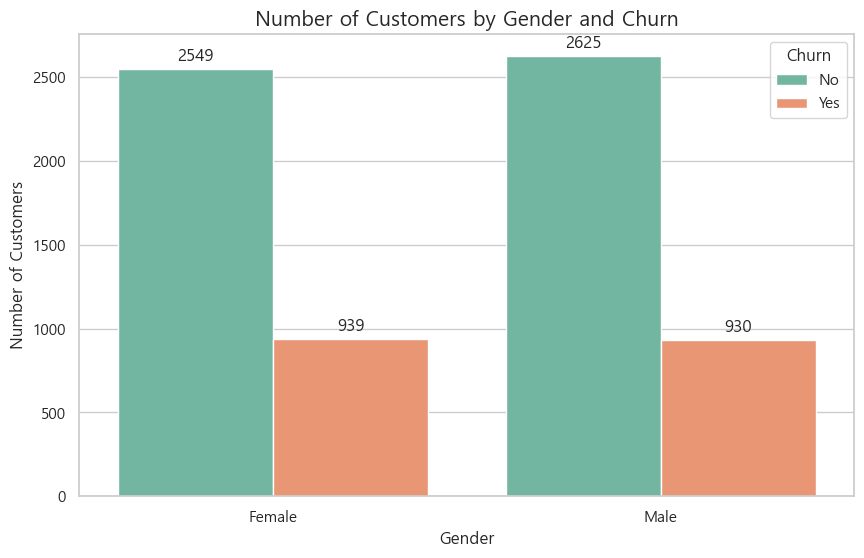

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'Churn_Numeric']

plt.figure(figsize=(10, 6))
# 1. countplot으로 성별별 이탈 여부 인원수 시각화
# x축은 성별, hue는 이탈 여부(Yes/No)
ax = sns.countplot(x='gender', hue='Churn', data=df, palette='Set2')

# 2. 막대 위에 인원수(Count) 레이블 추가
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

# 3. 그래프 꾸미기
plt.title('Number of Customers by Gender and Churn', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', loc='upper right')
plt.show()

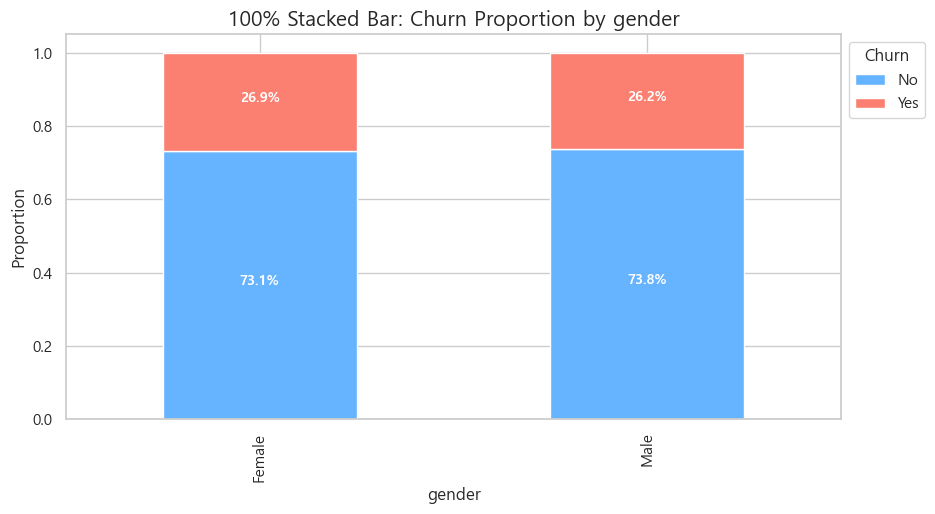

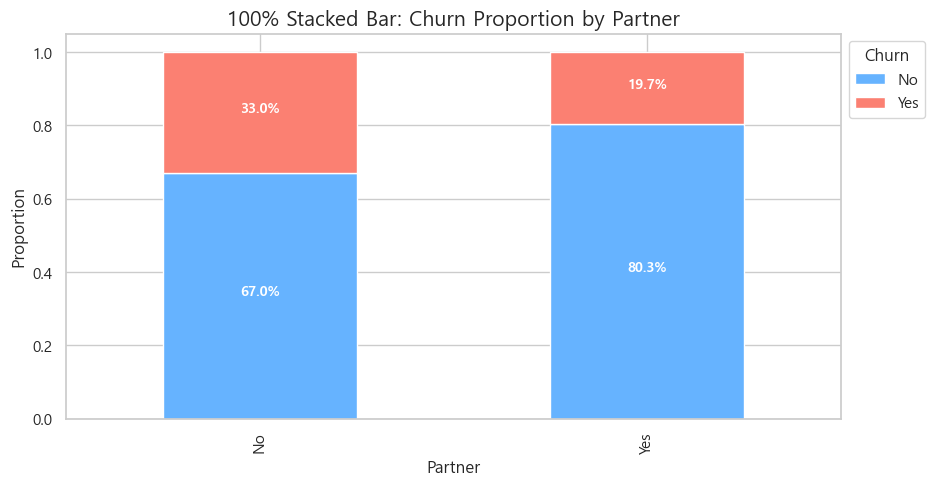

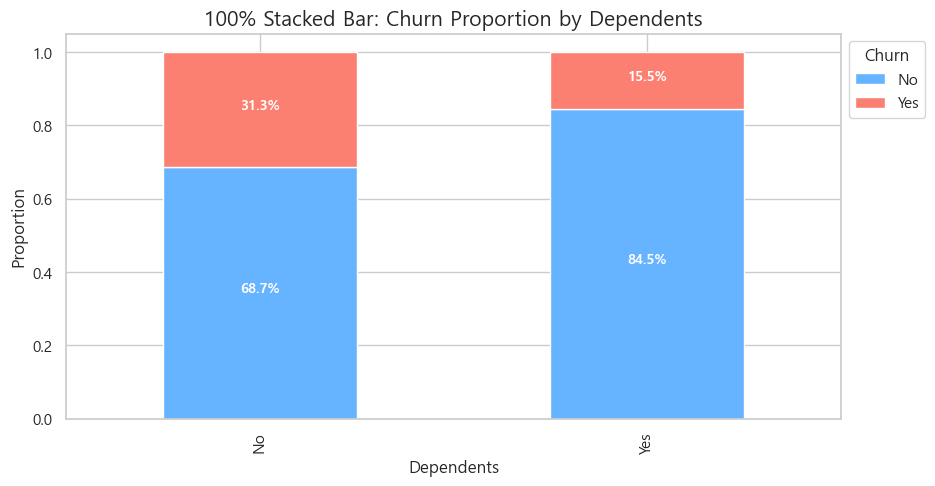

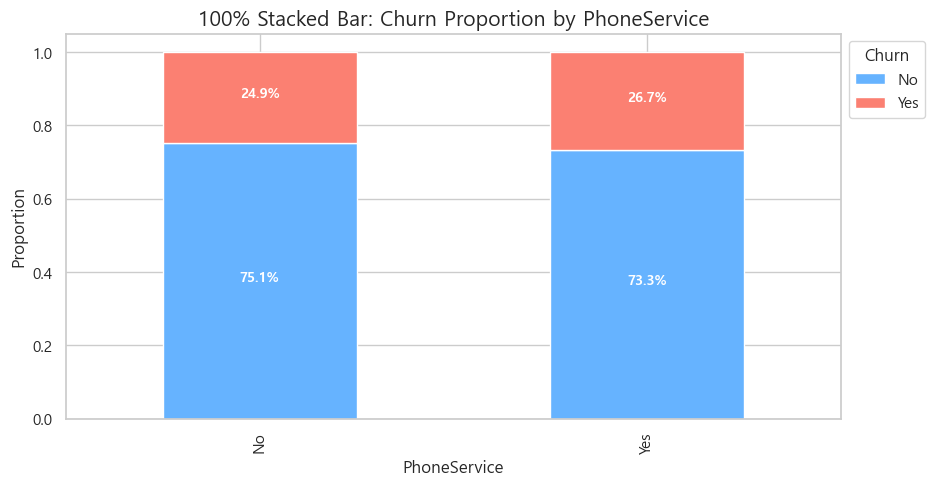

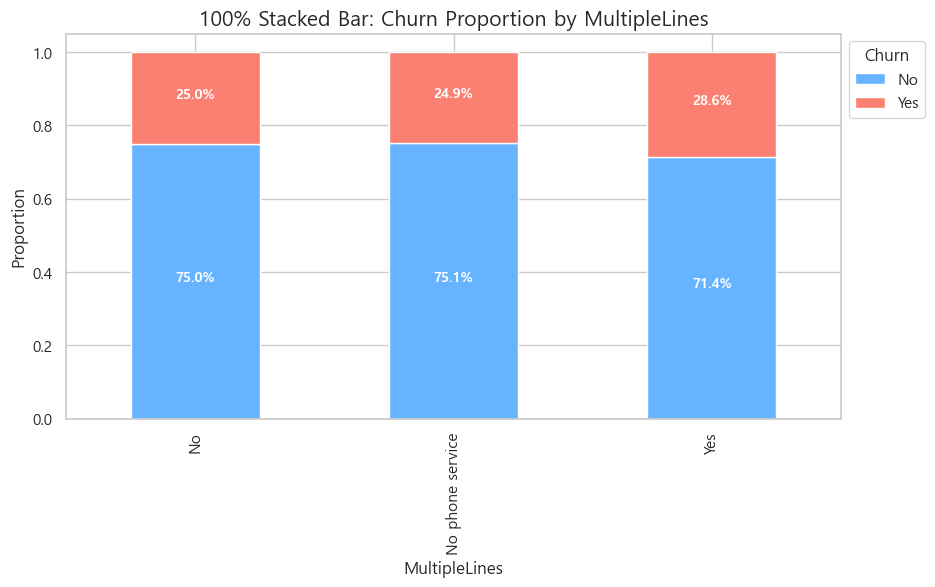

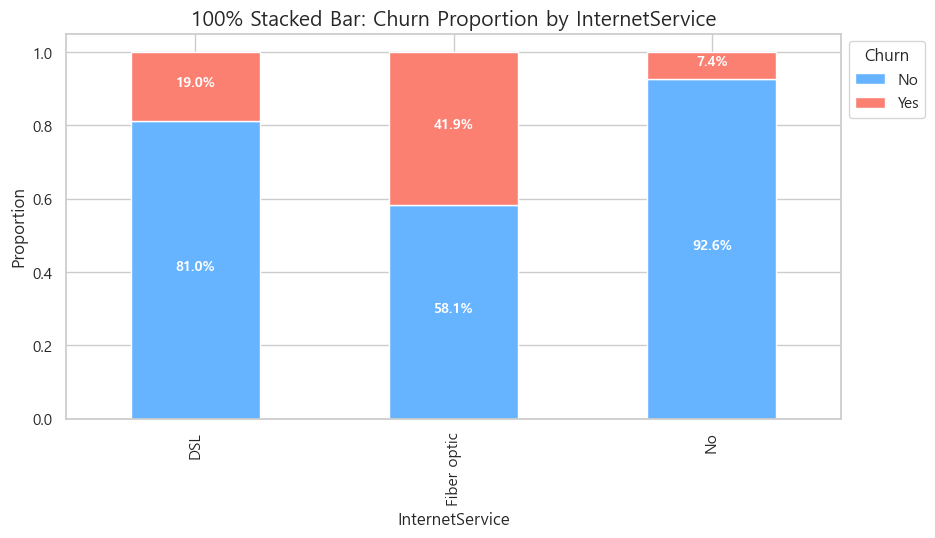

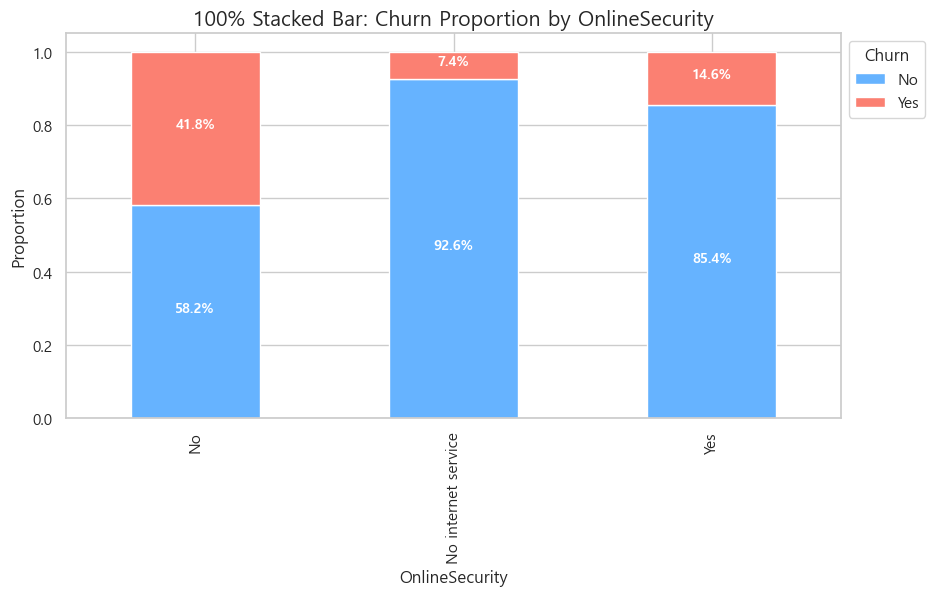

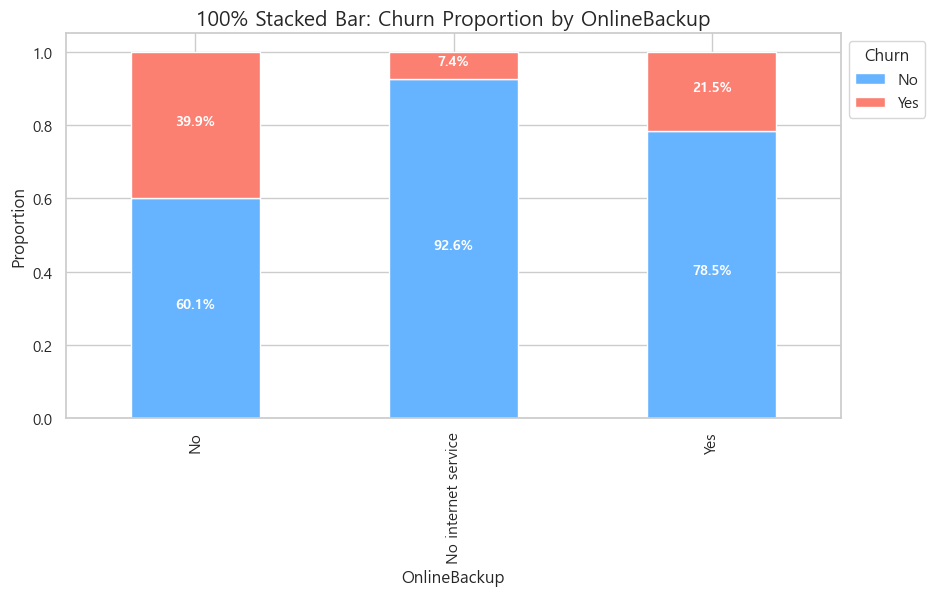

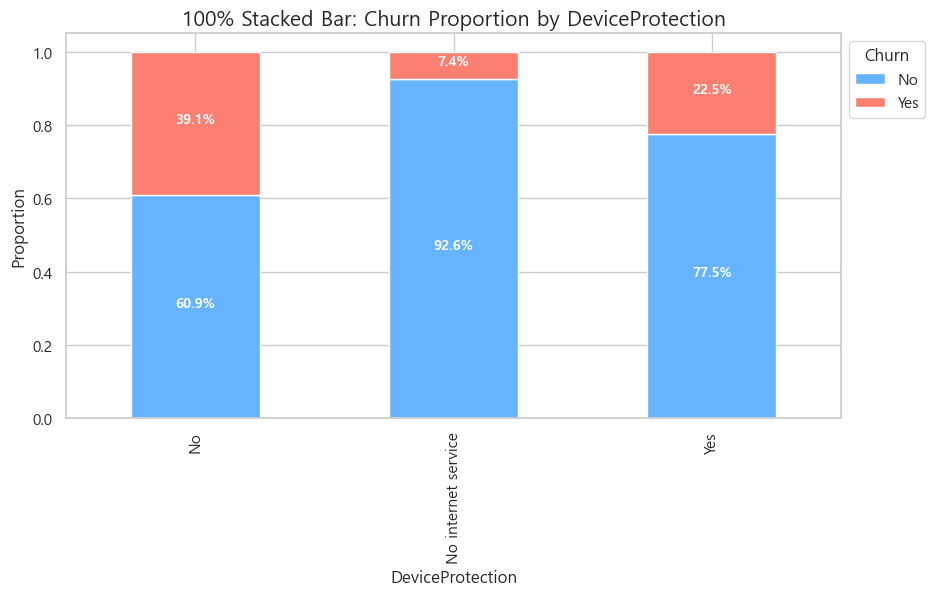

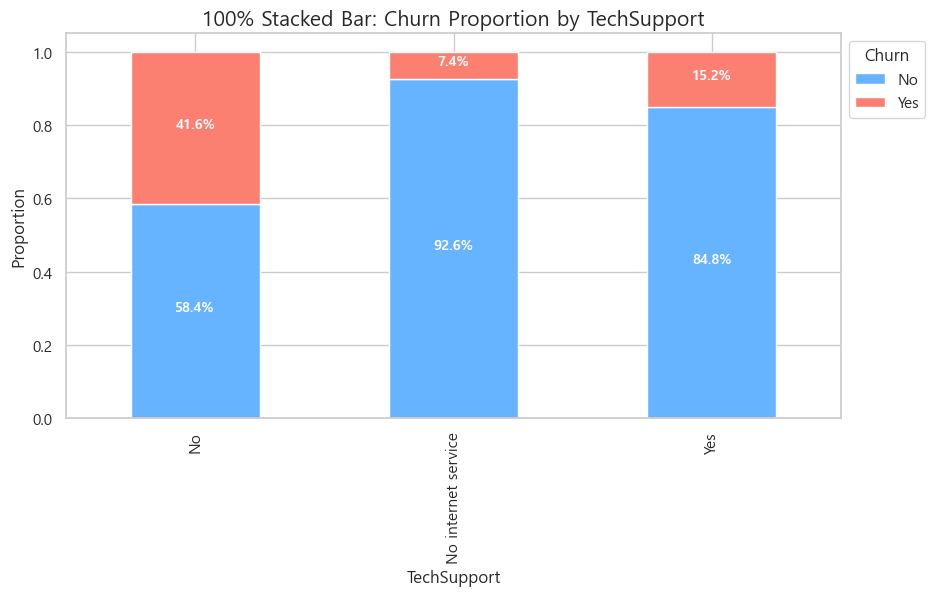

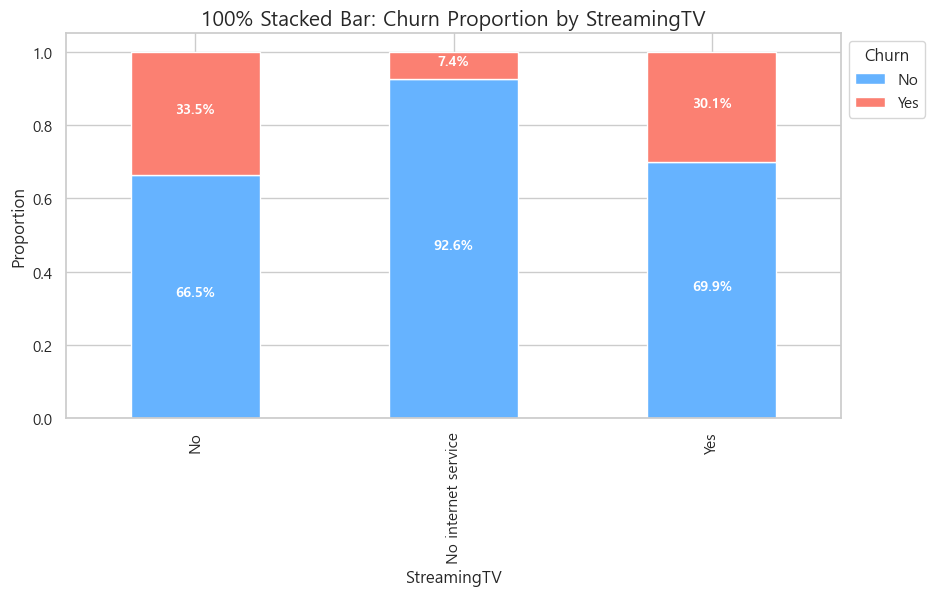

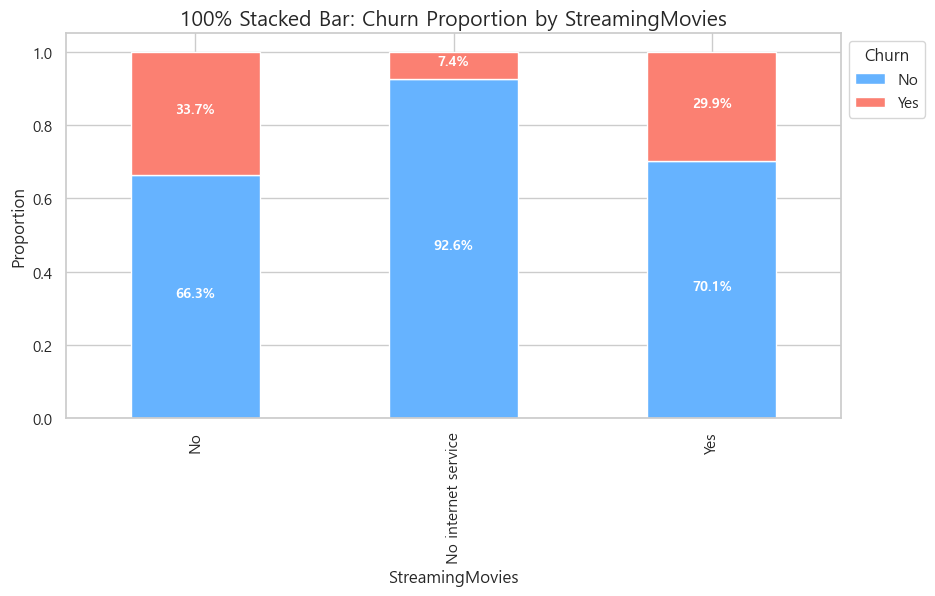

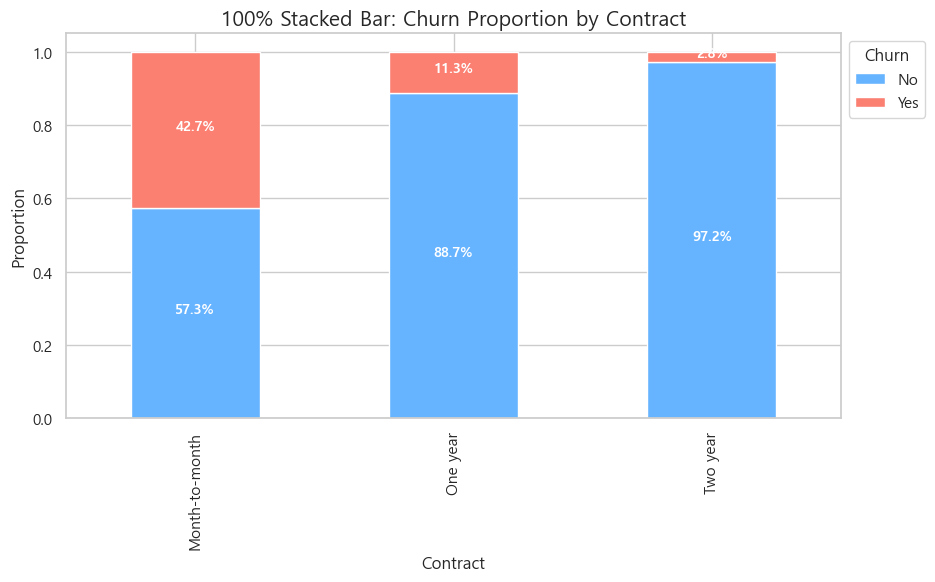

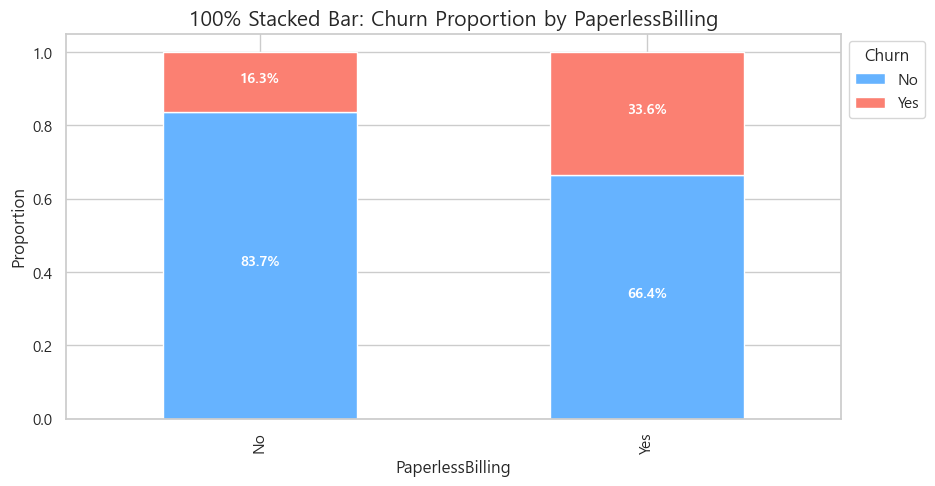

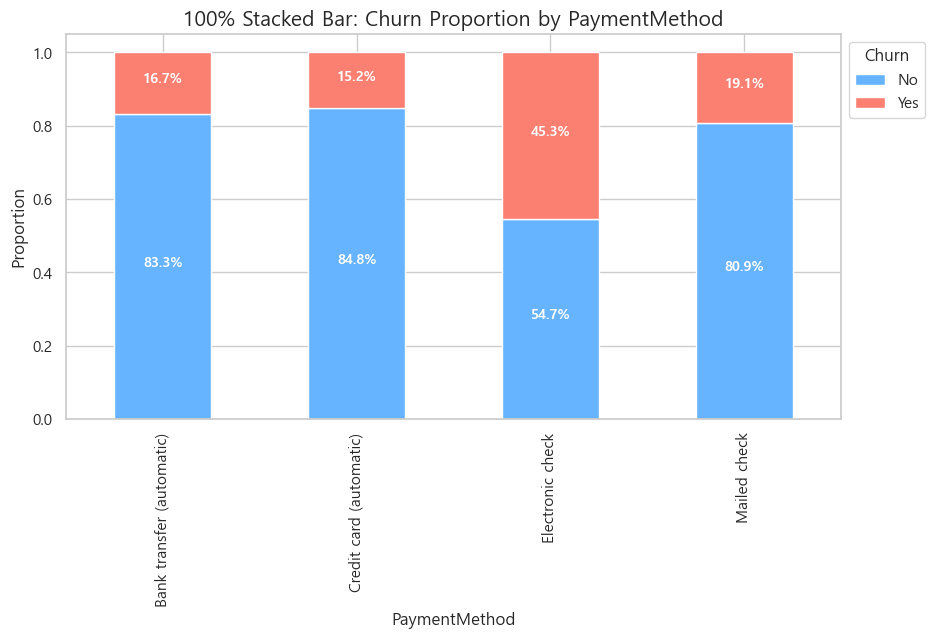

In [15]:

# 범주형 컬럼 리스트 생성 (ID와 타겟 제외)
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['customerID', 'Churn']]

for col in cat_cols:
    # 1. 교차표 생성 (인원수)
    cross_tab = pd.crosstab(df[col], df['Churn'])
    
    # 2. 행 단위로 합계가 1이 되도록 정규화 (전체를 100으로 설정)
    cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    
    # 3. 그래프 그리기
    ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(10, 5), color=['#66b3ff','#fb8072'])
    
    # 4. 막대 안에 비율(%) 표시하기
    for n, x in enumerate([*cross_tab_prop.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):
            plt.text(x=n,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{proportion*100:.1f}%', 
                     color="white",
                     fontsize=10,
                     fontweight="bold",
                     ha="center")

    plt.title(f'100% Stacked Bar: Churn Proportion by {col}', fontsize=15)
    plt.ylabel('Proportion')
    plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Numeric Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


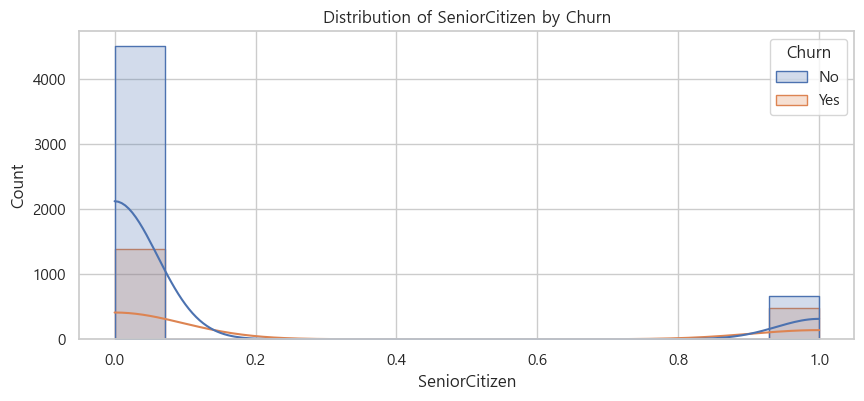

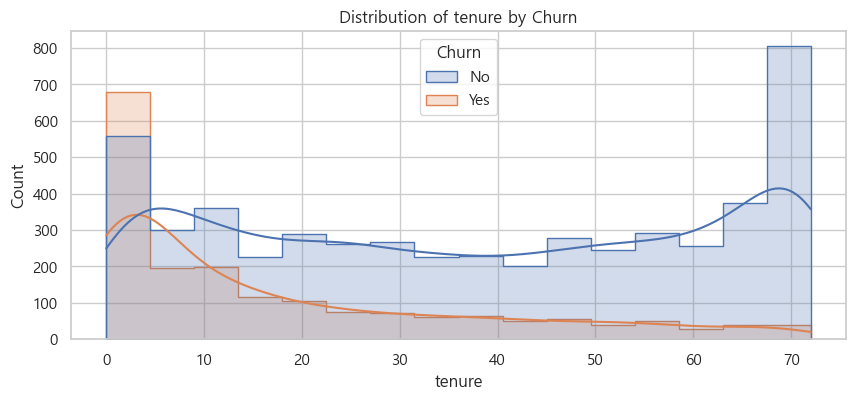

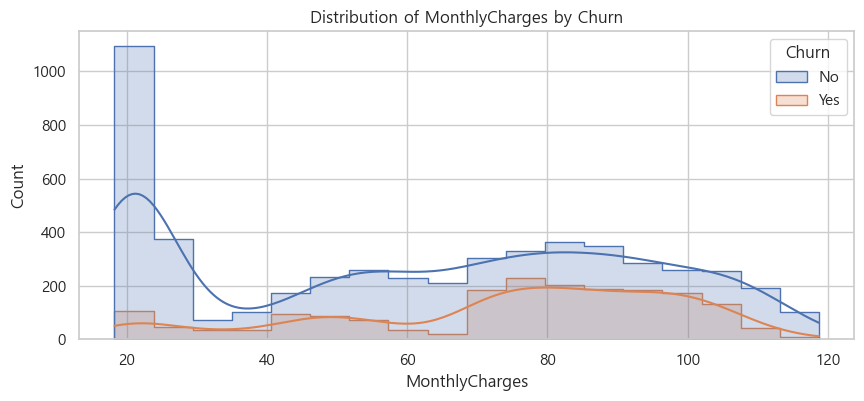

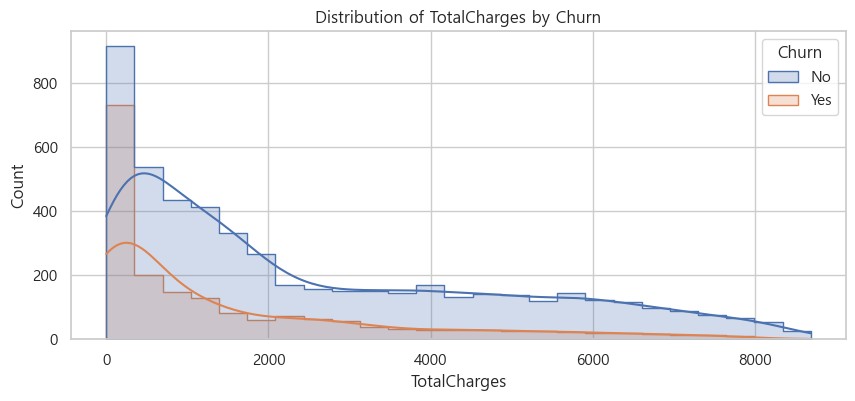

In [16]:


print("Numeric Columns:", num_cols)

# 수치형 데이터 시각화
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step")
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

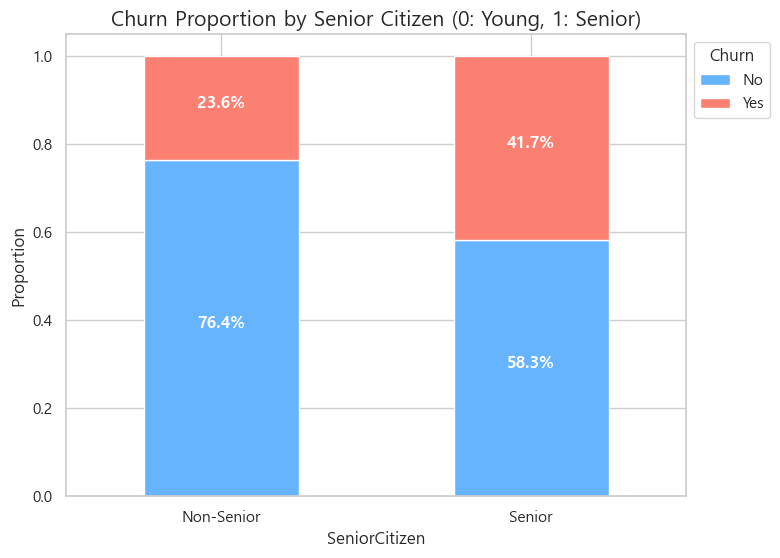

In [17]:
# 1. 교차표 생성 (0: 젊은 층, 1: 고령자)
cross_tab = pd.crosstab(df['SeniorCitizen'], df['Churn'])

# 2. 비율로 변환 (전체 합을 100%로 설정)
cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)

# 3. 그래프 그리기
ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff','#fb8072'])

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*cross_tab_prop.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.title('Churn Proportion by Senior Citizen (0: Young, 1: Senior)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0) # 라벨을 보기 쉽게 변경
plt.ylabel('Proportion')
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

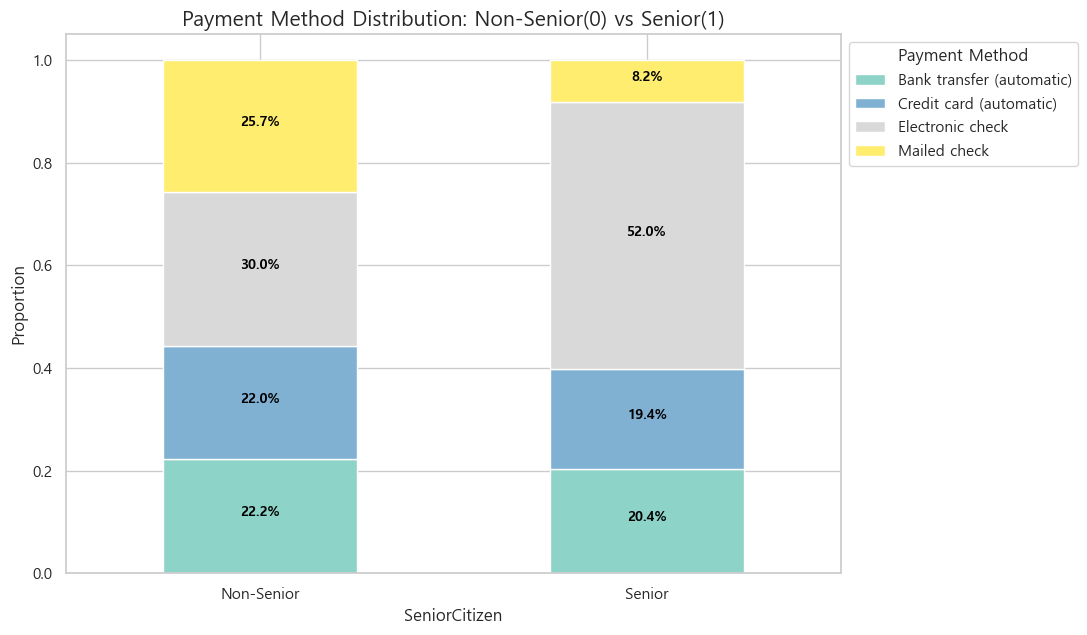

In [18]:
# 1. SeniorCitizen과 PaymentMethod의 교차표 생성
senior_payment = pd.crosstab(df['SeniorCitizen'], df['PaymentMethod'])

# 2. 비율로 변환 (각 그룹 내에서 어떤 결제수단을 많이 쓰는지)
senior_payment_prop = senior_payment.div(senior_payment.sum(1).astype(float), axis=0)

# 3. 시각화
ax = senior_payment_prop.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Set3')

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*senior_payment_prop.index.values]):
    cumulative_height = 0
    for col in senior_payment_prop.columns:
        proportion = senior_payment_prop.loc[x, col]
        plt.text(x=n,
                 y=cumulative_height + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold",
                 ha="center")
        cumulative_height += proportion

plt.title('Payment Method Distribution: Non-Senior(0) vs Senior(1)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0)
plt.ylabel('Proportion')
plt.legend(title='Payment Method', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\COM\AppData\Local\Temp\ipykernel_37260\531965128.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\COM\AppData\Local\Temp\ipykernel_37260\531965128.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\COM\AppData\Local\Temp\ipykernel_37260\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전
C:\Users\COM\AppData\Local\Temp\ipykernel_37260\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

<Figure size 1200x600 with 0 Axes>

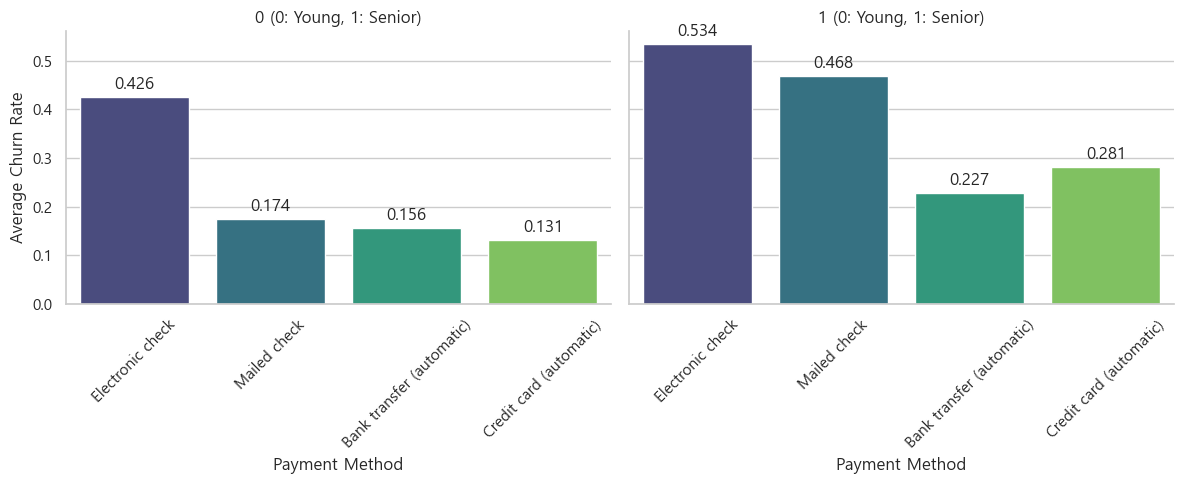

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고령자 여부에 따른 결제 수단별 이탈률 시각화
plt.figure(figsize=(12, 6))

# catplot은 여러 개의 그래프를 나란히 그리기에 아주 좋습니다.
g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen', 
                data=df, kind='bar', palette='viridis', ci=None, height=5, aspect=1.2)

# 각 막대 위에 수치(이탈률) 표시
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전

g.set_axis_labels("Payment Method", "Average Churn Rate")
g.set_titles("{col_name} (0: Young, 1: Senior)")
plt.tight_layout()
plt.show()

C:\Users\COM\AppData\Local\Temp\ipykernel_37260\2817978305.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Contract', data=senior_df, palette='magma', order=['Month-to-month', 'One year', 'Two year'])


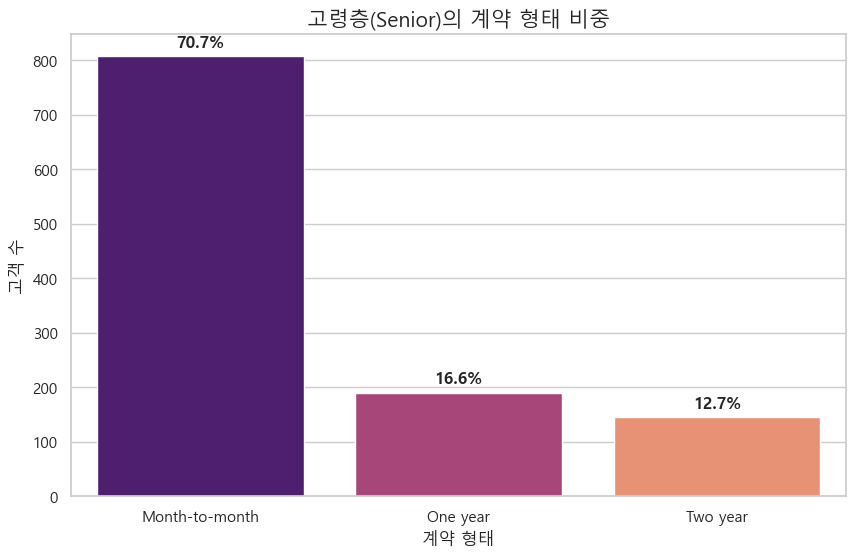

--- 고령층 계약 형태 상세 비율 ---
Contract
Month-to-month    70.665499
One year          16.637478
Two year          12.697023
Name: proportion, dtype: float64


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 고령자 데이터만 추출
senior_df = df[df['SeniorCitizen'] == 1]

# 2. 고령자 내 계약 형태 비율 계산
contract_counts = senior_df['Contract'].value_counts(normalize=True) * 100

# 3. 시각화 (파이 차트 또는 막대 그래프)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Contract', data=senior_df, palette='magma', order=['Month-to-month', 'One year', 'Two year'])

# 막대 위에 백분율 표시
total = len(senior_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.title('고령층(Senior)의 계약 형태 비중', fontsize=15)
plt.ylabel('고객 수')
plt.xlabel('계약 형태')
plt.show()

print("--- 고령층 계약 형태 상세 비율 ---")
print(contract_counts)

C:\Users\COM\AppData\Local\Temp\ipykernel_37260\3883665455.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TenureGroup', data=senior_only, palette='magma', order=order_list, ax=axes[0])
C:\Users\COM\AppData\Local\Temp\ipykernel_37260\3883665455.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TenureGroup', data=young_only, palette='viridis', order=order_list, ax=axes[1])


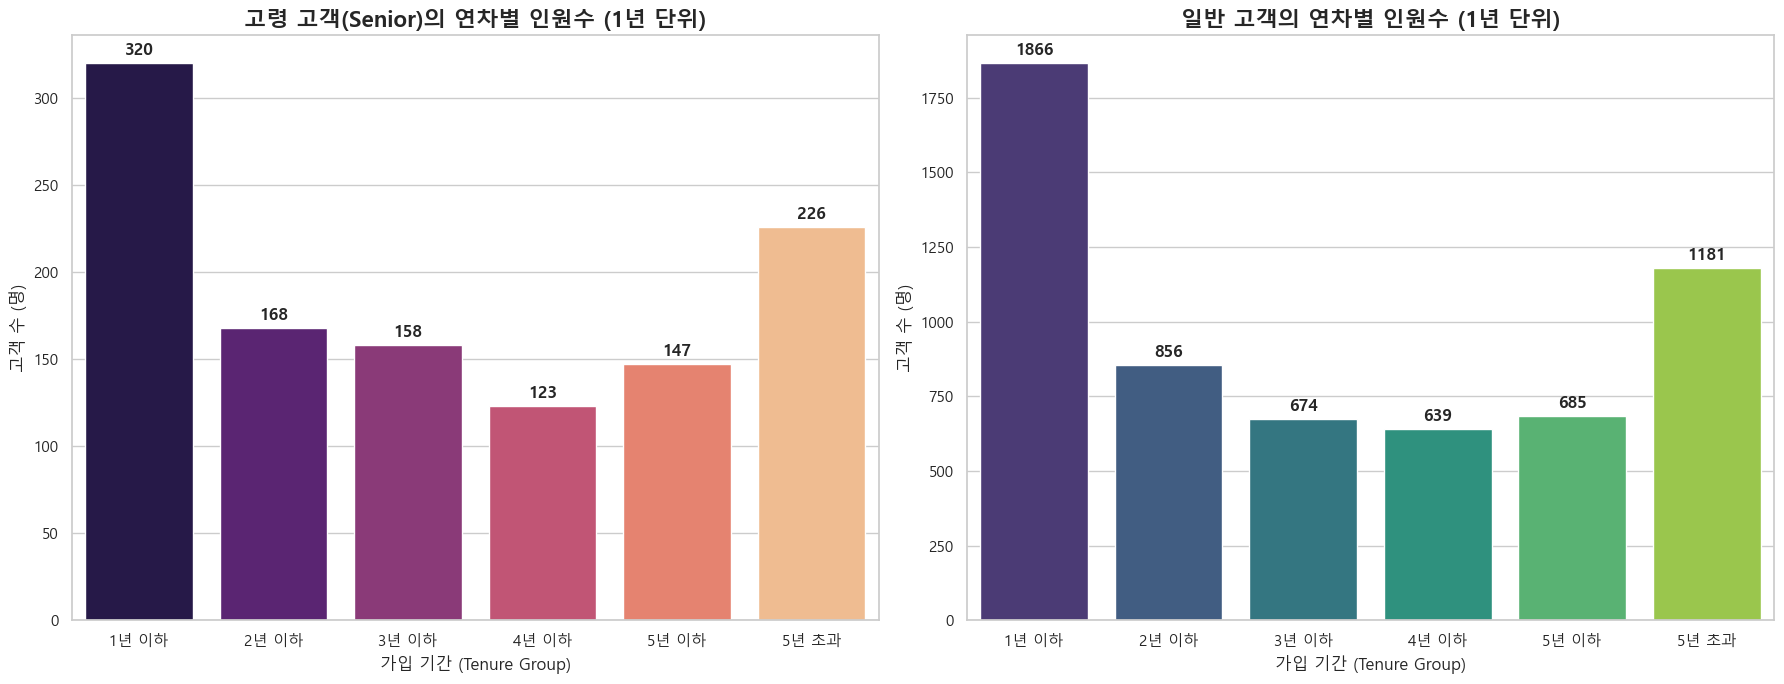

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 캔버스 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 새로 정의한 1년 단위 순서 설정
order_list = ['1년 이하', '2년 이하', '3년 이하', '4년 이하', '5년 이하', '5년 초과']

# 2. [왼쪽 - Index 0] 고령 고객 (SeniorCitizen == 1)
senior_only = df[df['SeniorCitizen'] == 1]
sns.countplot(x='TenureGroup', data=senior_only, palette='magma', order=order_list, ax=axes[0])
axes[0].set_title('고령 고객(Senior)의 연차별 인원수 (1년 단위)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('가입 기간 (Tenure Group)', fontsize=12)
axes[0].set_ylabel('고객 수 (명)', fontsize=12)

# 막대 위 숫자 표시
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3, fontweight='bold')

# 3. [오른쪽 - Index 1] 일반 고객 (SeniorCitizen == 0)
young_only = df[df['SeniorCitizen'] == 0]
sns.countplot(x='TenureGroup', data=young_only, palette='viridis', order=order_list, ax=axes[1])
axes[1].set_title('일반 고객의 연차별 인원수 (1년 단위)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('가입 기간 (Tenure Group)', fontsize=12)
axes[1].set_ylabel('고객 수 (명)', fontsize=12)

# 막대 위 숫자 표시
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', padding=3, fontweight='bold')

# 레이아웃 정렬 및 출력
plt.tight_layout()
plt.show()

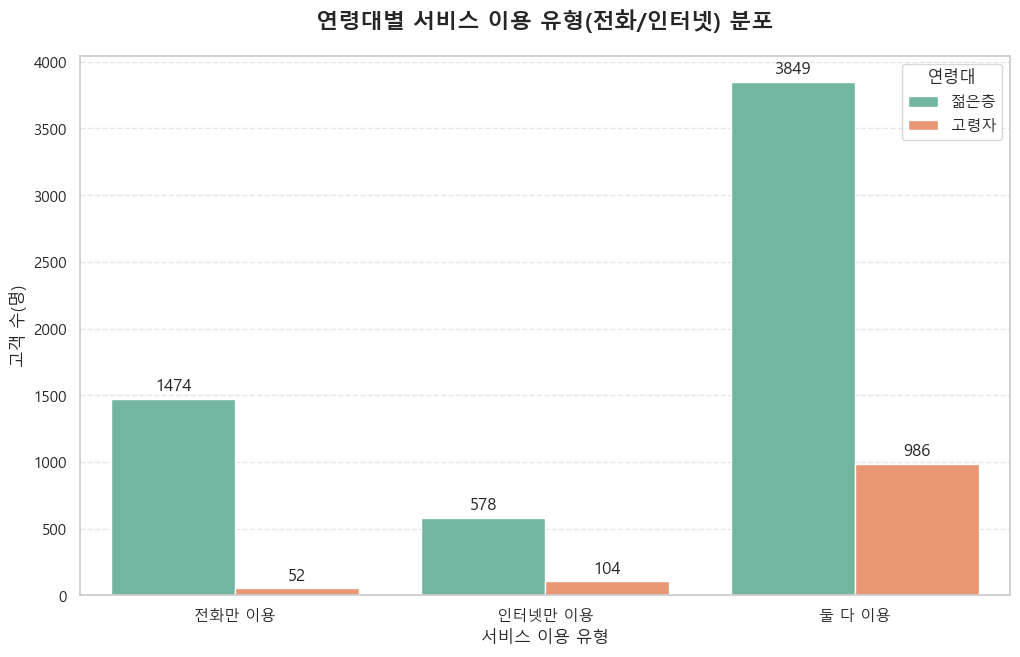

--- 연령대별 서비스 이용 유형 비율 (%) ---
ServiceType     둘 다 이용  인터넷만 이용     전화만 이용
연령대                                       
고령자          86.339755  9.10683   4.553415
젊은층          65.226233  9.79495  24.978817


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 서비스 이용 유형 분류 함수 정의
def classify_service(row):
    has_phone = (row['PhoneService'] == 'Yes')
    has_internet = (row['InternetService'] != 'No')
    
    if has_phone and has_internet:
        return '둘 다 이용'
    elif has_phone:
        return '전화만 이용'
    elif has_internet:
        return '인터넷만 이용'
    else:
        return '둘 다 미이용'

# 2. 데이터 적용 및 연령대 라벨링
df_combo = df.copy()
df_combo['ServiceType'] = df_combo.apply(classify_service, axis=1)
df_combo['연령대'] = df_combo['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})

# 3. 시각화 (연령대별 서비스 유형 비중)
plt.figure(figsize=(12, 7))

# 전체적인 규모와 연령대별 차이를 동시에 보기 위해 countplot 사용
ax = sns.countplot(data=df_combo, x='ServiceType', hue='연령대', 
                   order=['전화만 이용', '인터넷만 이용', '둘 다 이용'],
                   palette='Set2')

# 막대 위에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('연령대별 서비스 이용 유형(전화/인터넷) 분포', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('서비스 이용 유형', fontsize=12)
plt.ylabel('고객 수(명)', fontsize=12)
plt.legend(title='연령대')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 4. 수치로도 확인 (비율)
print("--- 연령대별 서비스 이용 유형 비율 (%) ---")
print(pd.crosstab(df_combo['연령대'], df_combo['ServiceType'], normalize='index') * 100)

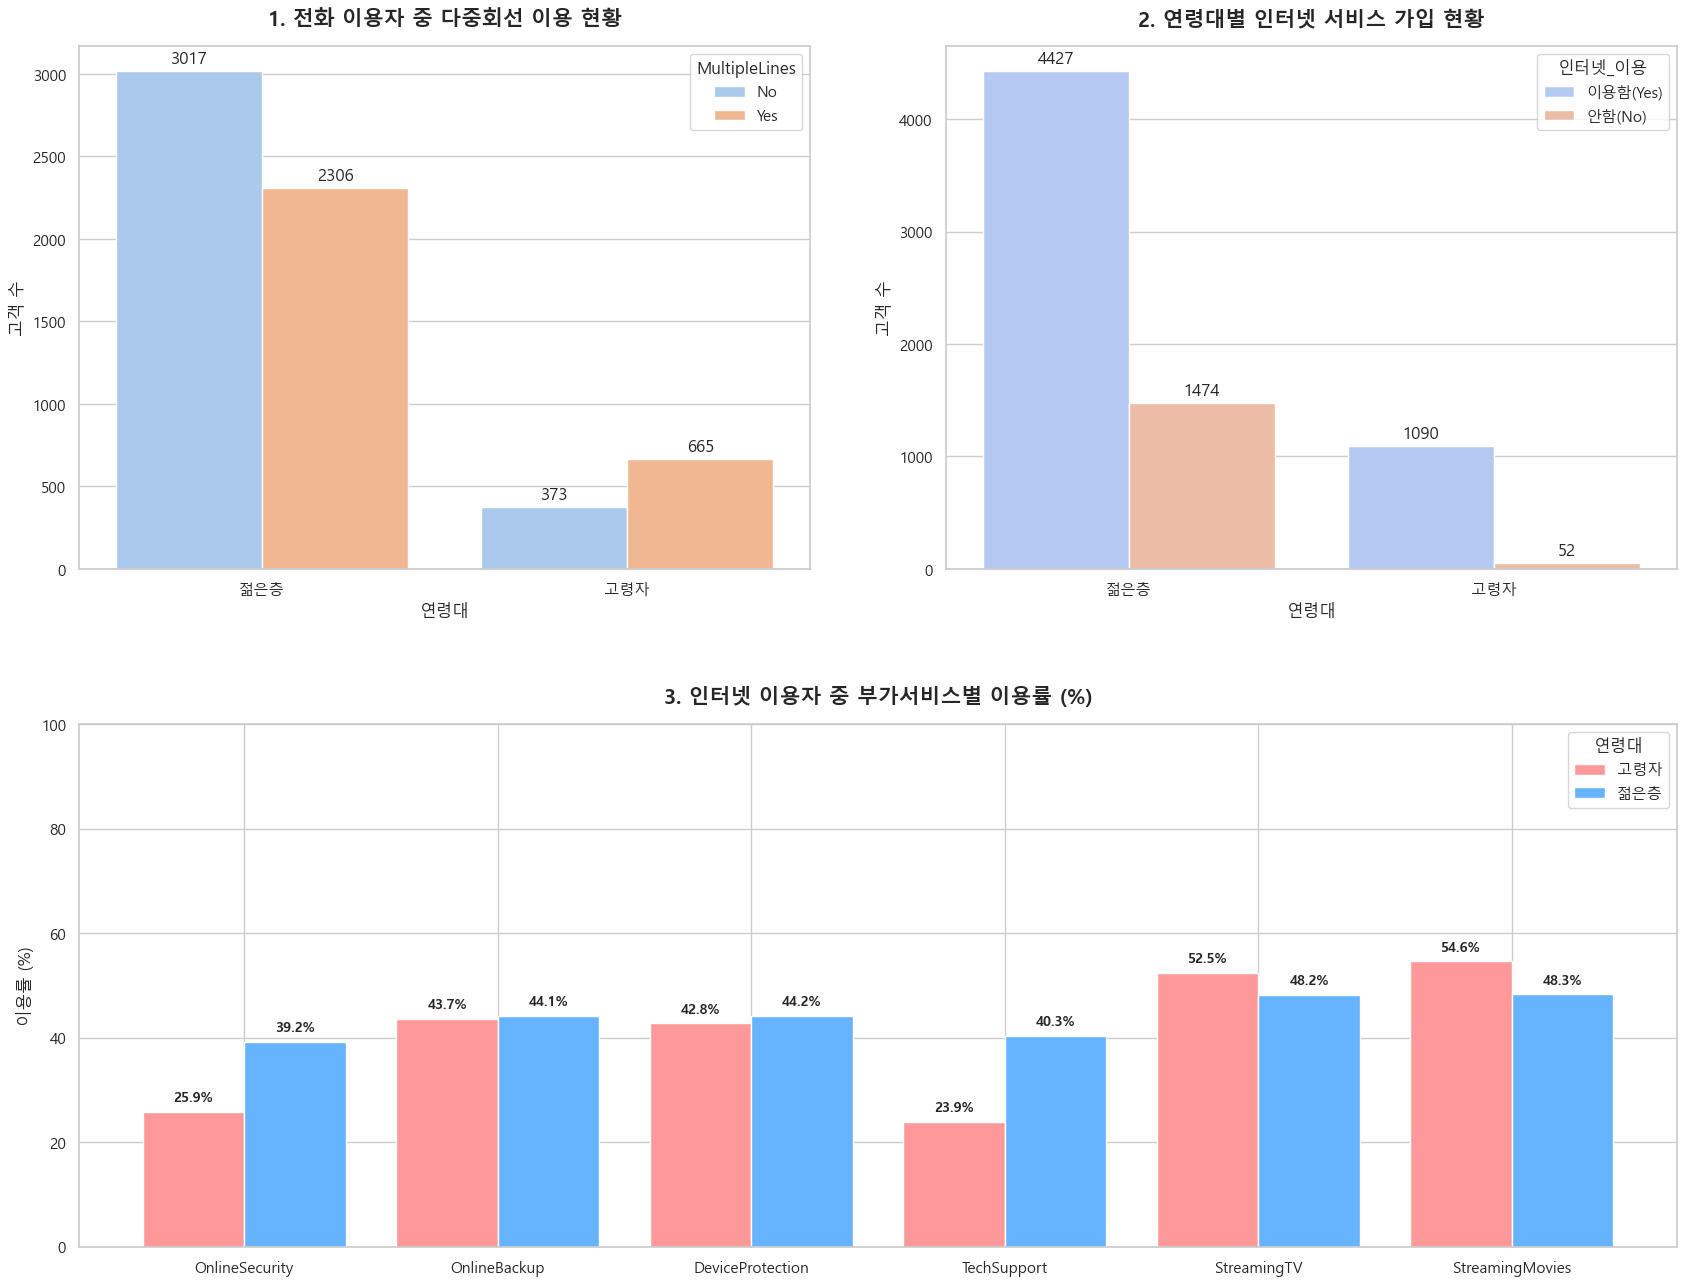

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 준비
df_plot = df.copy()
df_plot['연령대'] = df_plot['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})
df_plot['인터넷_이용'] = df_plot['InternetService'].apply(lambda x: '안함(No)' if x == 'No' else '이용함(Yes)')

# 2. 캔버스 설정 (2행 2열 구조, 3번 그래프는 아래쪽 전체 사용)
fig = plt.figure(figsize=(18, 14))
ax1 = plt.subplot(2, 2, 1) # 1행 1열: 전화
ax2 = plt.subplot(2, 2, 2) # 1행 2열: 인터넷 가입
ax3 = plt.subplot(2, 1, 2) # 2행 전체: 인터넷 부가서비스

# --- [그래프 1: 전화 이용자 내 다중회선 현황] ---
phone_users = df_plot[df_plot['PhoneService'] == 'Yes']
sns.countplot(data=phone_users, x='연령대', hue='MultipleLines', ax=ax1, palette='pastel')
ax1.set_title('1. 전화 이용자 중 다중회선 이용 현황', fontsize=15, fontweight='bold', pad=15)
ax1.set_ylabel('고객 수')
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', padding=3)

# --- [그래프 2: 연령대별 인터넷 서비스 가입 현황] ---
sns.countplot(data=df_plot, x='연령대', hue='인터넷_이용', ax=ax2, palette='coolwarm')
ax2.set_title('2. 연령대별 인터넷 서비스 가입 현황', fontsize=15, fontweight='bold', pad=15)
ax2.set_ylabel('고객 수')
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', padding=3)

# --- [그래프 3: 인터넷 이용자 내 부가서비스 이용률 (아래쪽)] ---
it_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_users = df_plot[df_plot['InternetService'] != 'No']
it_usage = internet_users.groupby('연령대')[it_services].apply(lambda x: (x == 'Yes').mean() * 100).T

it_usage.plot(kind='bar', ax=ax3, color=['#ff9999', '#66b3ff'], width=0.8)
ax3.set_title('3. 인터넷 이용자 중 부가서비스별 이용률 (%)', fontsize=15, fontweight='bold', pad=15)
ax3.set_ylabel('이용률 (%)')
ax3.set_ylim(0, 100)
ax3.legend(title='연령대', loc='upper right')
plt.xticks(rotation=0) # 라벨 가독성을 위해 회전 고정

# 수치 표시
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, fontweight='bold')

plt.tight_layout(pad=4.0)
plt.show()

In [66]:
# 인터넷을 이용하지 않는 사람(No) 중 부가서비스를 하나라도 'Yes'로 가진 사람 찾기
it_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# 인터넷 미이용자 필터링
no_internet = df[df['InternetService'] == 'No']

# 부가서비스 중 하나라도 'Yes'인 경우를 합산
error_data = no_internet[(no_internet[it_services] == 'Yes').any(axis=1)]

print(f"인터넷 미이용자 중 부가서비스 이용자 수: {len(error_data)}명")

if len(error_data) == 0:
    print("✅ 데이터가 논리적으로 완벽합니다! 인터넷 없이 부가서비스를 쓰는 사람은 없습니다.")
else:
    print("⚠️ 데이터에 오류가 있습니다. 확인이 필요합니다.")

인터넷 미이용자 중 부가서비스 이용자 수: 0명
✅ 데이터가 논리적으로 완벽합니다! 인터넷 없이 부가서비스를 쓰는 사람은 없습니다.


In [15]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


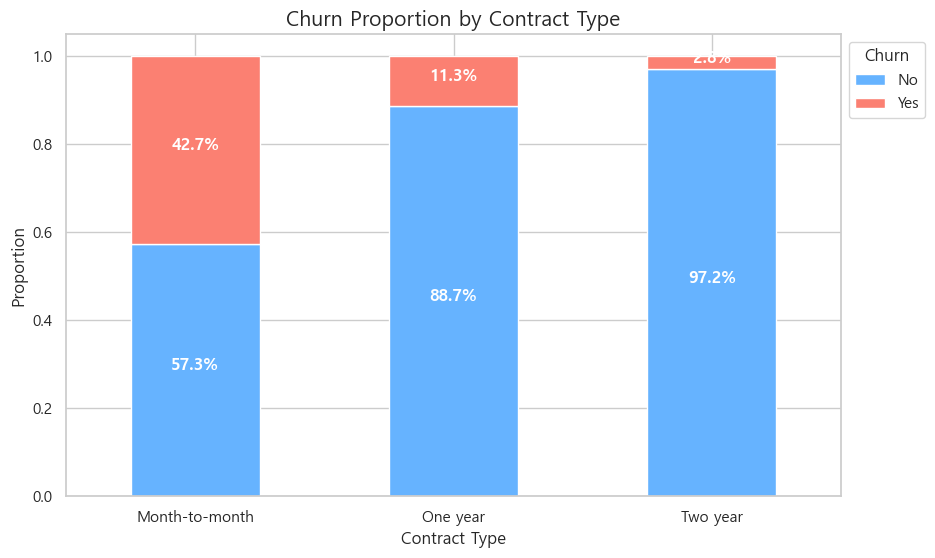

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 계약 기간(Contract)과 이탈(Churn)의 교차표 생성
contract_churn = pd.crosstab(df['Contract'], df['Churn'])

# 2. 비율로 변환 (각 계약 형태 내에서 이탈 비중 계산)
contract_prop = contract_churn.div(contract_churn.sum(1).astype(float), axis=0)

# 3. 그래프 그리기
ax = contract_prop.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#66b3ff','#fb8072'])

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*contract_prop.index.values]):
    for (proportion, y_loc) in zip(contract_prop.loc[x],
                                   contract_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.title('Churn Proportion by Contract Type', fontsize=15)
plt.ylabel('Proportion')
plt.xlabel('Contract Type')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

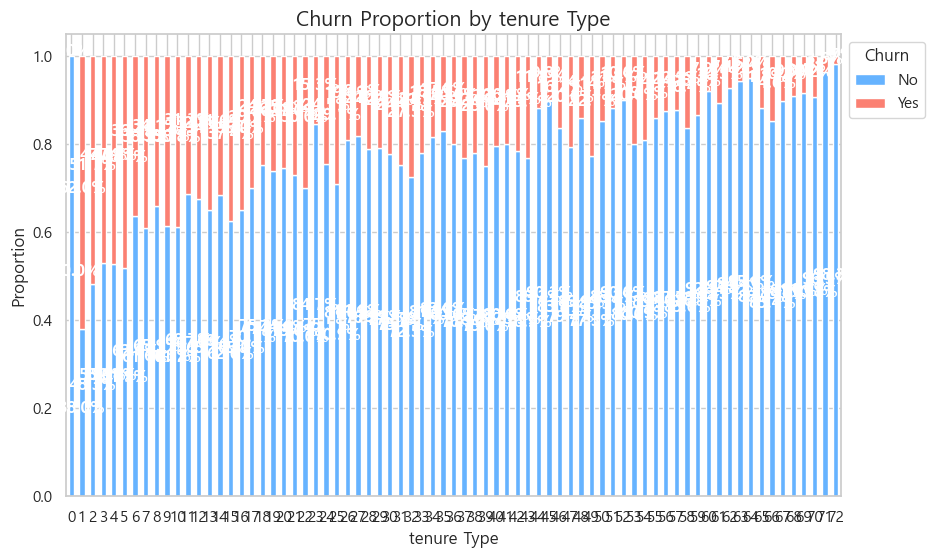

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 계약 기간(Contract)과 이탈(Churn)의 교차표 생성
contract_churn = pd.crosstab(df['tenure'], df['Churn'])

# 2. 비율로 변환 (각 계약 형태 내에서 이탈 비중 계산)
contract_prop = contract_churn.div(contract_churn.sum(1).astype(float), axis=0)

# 3. 그래프 그리기
ax = contract_prop.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#66b3ff','#fb8072'])

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*contract_prop.index.values]):
    for (proportion, y_loc) in zip(contract_prop.loc[x],
                                   contract_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.title('Churn Proportion by tenure Type', fontsize=15)
plt.ylabel('Proportion')
plt.xlabel('tenure Type')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# 3. 데이터 전처리 (Preprocessing)
- 불필요한 컬럼 제거 (`customerID`, 시각화용 `Churn_Numeric`)
- 결측치 처리 (이미 위에서 수행함)

In [36]:
# 불필요한 컬럼 제거
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

if 'Churn_Numeric' in df.columns:
    df = df.drop('Churn_Numeric', axis=1)

# 결측치 재확인
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
TenureGroup         0
ServiceCount        0
dtype: int64


# 4. 특성 엔지니어링 (Feature Engineering)
- `TenureGroup`: 가입 기간을 그룹화
- `ServicesCount`: 가입한 부가 서비스 수
- `ContractType`: 계약 형태 단순화 (선택 사항)

In [47]:
# 1년 단위로 촘촘하게 다시 그룹화
def tenure_group_refined(tenure):
    if tenure <= 12:
        return '1년 이하'
    elif tenure <= 24:
        return '2년 이하'
    elif tenure <= 36:
        return '3년 이하'
    elif tenure <= 48:
        return '4년 이하'
    elif tenure <= 60:
        return '5년 이하'
    else:
        return '5년 초과'

df['TenureGroup'] = df['tenure'].apply(tenure_group_refined)

# 순서 고정을 위한 리스트 (그래프 그릴 때 사용)
order_list = ['1년 이하', '2년 이하', '3년 이하', '4년 이하', '5년 이하', '5년 초과']

display(df[['tenure', 'TenureGroup']].head())

,tenure,TenureGroup
0,1,1년 이하
1,34,3년 이하
2,2,1년 이하
3,45,4년 이하
4,2,1년 이하


In [38]:
# 1. 조건에 맞는 데이터 필터링 (InternetService가 'No'이면서 PhoneService가 'Yes')
only_phone_customers = df[(df['InternetService'] == 'No') & (df['PhoneService'] == 'Yes')]

# 2. 해당 고객 수 출력
print(f"인터넷 없이 전화만 사용하는 고객 수: {len(only_phone_customers)}명")

# 3. 데이터 상단 확인
only_phone_customers.head()

인터넷 없이 전화만 사용하는 고객 수: 1526명


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,ServiceCount
11,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.80,No,1-2 Years,1
16,Female,0,No,No,52,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,One year,No,Mailed check,20.65,1022.95,No,4-5 Years,1
21,Male,0,Yes,No,12,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,One year,No,Bank transfer (automatic),19.80,202.25,No,0-1 Year,1
22,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes,0-1 Year,1
33,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No,0-1 Year,1


In [30]:
# 1. PhoneService가 No인데 MultipleLines가 Yes인 모순된 데이터 찾기
issue_customers = df[(df['PhoneService'] == 'No') & (df['MultipleLines'] == 'Yes')]

# 2. 결과 출력
print(f"모순된 데이터 건수: {len(issue_customers)}건")

# 3. 만약 있다면 데이터 확인
if len(issue_customers) > 0:
    print(issue_customers[['PhoneService', 'MultipleLines']])
else:
    print("데이터에 모순이 없습니다. (PhoneService가 No인 경우 MultipleLines는 모두 No 또는 No phone service입니다.)")

모순된 데이터 건수: 0건
데이터에 모순이 없습니다. (PhoneService가 No인 경우 MultipleLines는 모두 No 또는 No phone service입니다.)


C:\Users\COM\AppData\Local\Temp\ipykernel_37260\532139121.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)
C:\Users\COM\AppData\Local\Temp\ipykernel_37260\532139121.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)


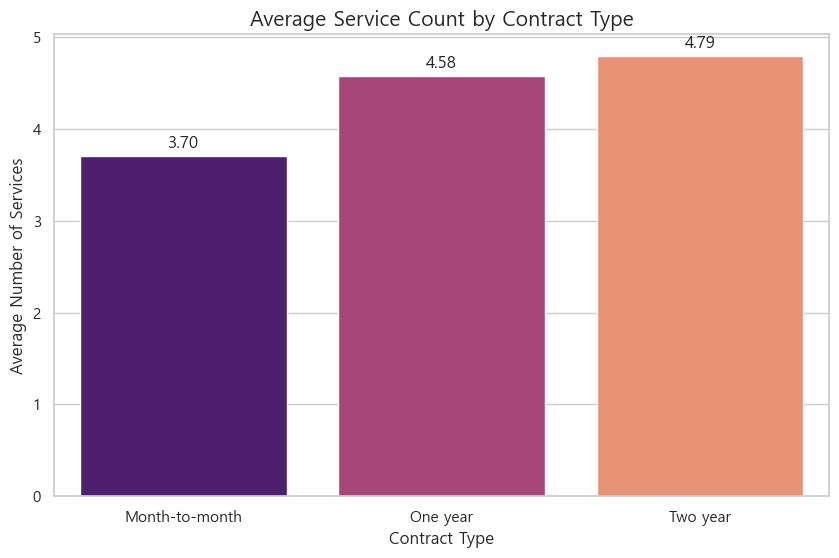

In [24]:
# 1. 서비스 관련 컬럼 리스트 (인터넷 서비스 자체와 부가 서비스들)
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# 2. 'Yes'인 경우를 1로 계산하여 합산 (InternetService는 'No'가 아니면 이용 중으로 간주할 수 있음)
df['ServiceCount'] = (df[service_cols] == 'Yes').sum(axis=1)
# InternetService가 'No'가 아닌 경우도 하나의 서비스로 추가
df['ServiceCount'] += (df['InternetService'] != 'No').astype(int)

# 3. 계약기간(Contract)별 서비스카운트(ServiceCount) 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)

# 막대 위에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Average Service Count by Contract Type', fontsize=15)
plt.ylabel('Average Number of Services')
plt.xlabel('Contract Type')
plt.show()

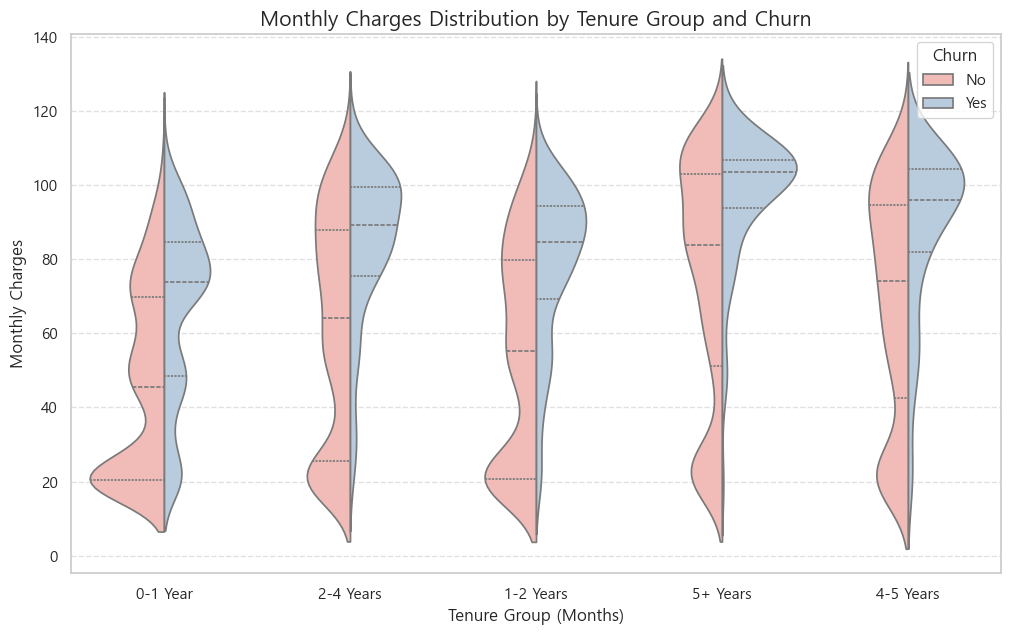

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 가입 기간 그룹(TenureGroup)별로 MonthlyCharges와 이탈 여부를 시각화
plt.figure(figsize=(12, 7))

# 바이올린 플롯으로 요금 분포 확인
sns.violinplot(x='TenureGroup', y='MonthlyCharges', hue='Churn', 
               data=df, split=True, palette='Pastel1', inner="quartile")

plt.title('Monthly Charges Distribution by Tenure Group and Churn', fontsize=15)
plt.xlabel('Tenure Group (Months)')
plt.ylabel('Monthly Charges')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Churn', loc='upper right')
plt.show()

In [26]:
# 1. 전체 고객 대상 서비스 개수별 이탈률 계산
overall_service_churn = df.groupby('ServiceCount')['Churn_Numeric'].mean().reset_index()

# 2. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=overall_service_churn, palette='coolwarm')

# 막대 위에 이탈률 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

# 전체 평균 이탈률 선 표시
plt.axhline(df['Churn_Numeric'].mean(), color='red', linestyle='--', label='Overall Avg Churn Rate')

plt.title('Churn Rate by Service Count (All Customers)', fontsize=15)
plt.xlabel('Number of Services Used')
plt.ylabel('Average Churn Rate')
plt.legend()
plt.show()

KeyError: 'Column not found: Churn_Numeric'

C:\Users\COM\AppData\Local\Temp\ipykernel_15888\4243815415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=service_churn_longterm, palette='viridis')


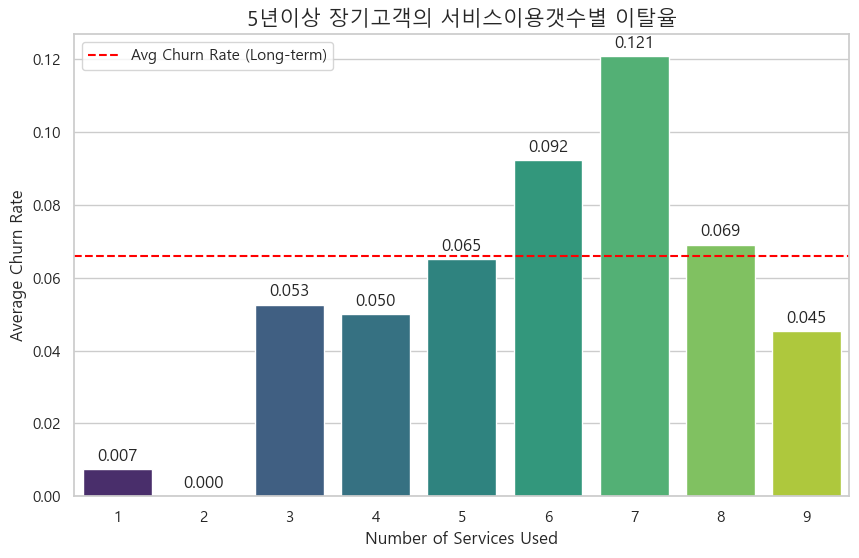

In [ ]:
# 1. 5년 이상(60개월 초과) 장기 고객 데이터 필터링
long_term_customers = df[df['tenure'] > 60].copy()

# 2. 서비스 개수(ServiceCount)별 이탈률 계산
service_churn_longterm = long_term_customers.groupby('ServiceCount')['Churn_Numeric'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=service_churn_longterm, palette='viridis')

# 막대 위에 이탈률 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('5년이상 장기고객의 서비스이용갯수별 이탈율', fontsize=15)
plt.xlabel('Number of Services Used')
plt.ylabel('Average Churn Rate')
plt.axhline(long_term_customers['Churn_Numeric'].mean(), color='red', linestyle='--', label='Avg Churn Rate (Long-term)')
plt.legend()
plt.show()

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 집계
summary_df = df.groupby('ServiceCount').agg({
    'MonthlyCharges': 'mean',
    'Churn_Numeric': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 1. 평균 요금 (막대 그래프)
sns.barplot(x='ServiceCount', y='MonthlyCharges', data=summary_df, ax=ax1, alpha=0.6, palette='Blues')
ax1.set_ylabel('평균 월 요금 ($)', fontsize=12, color='tab:blue')
ax1.set_xlabel('서비스 이용 개수', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 막대 위에 요금 수치 표시
for i, v in enumerate(summary_df['MonthlyCharges']):
    ax1.text(i, v + 2, f'${v:.1f}', ha='center', color='tab:blue', fontweight='bold')

# 2. 이탈률 (꺾은선 그래프) - 축 공유
ax2 = ax1.twinx()
sns.lineplot(x=range(len(summary_df)), y=summary_df['Churn_Numeric'], ax=ax2, color='tab:red', marker='o', linewidth=3, markersize=10)
ax2.set_ylabel('이탈률 (0~1)', fontsize=12, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 이탈률 수치 표시 (%)
for i, v in enumerate(summary_df['Churn_Numeric']):
    ax2.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', color='tab:red', fontweight='bold')

# 제목 설정 (한글)
plt.title('서비스 이용 개수에 따른 요금과 이탈률의 관계: 3개 지점의 위험성', fontsize=16, pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

KeyError: "Column(s) ['Churn_Numeric'] do not exist"

C:\Users\COM\AppData\Local\Temp\ipykernel_37260\1065610942.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ServiceCount', data=df, palette='viridis')


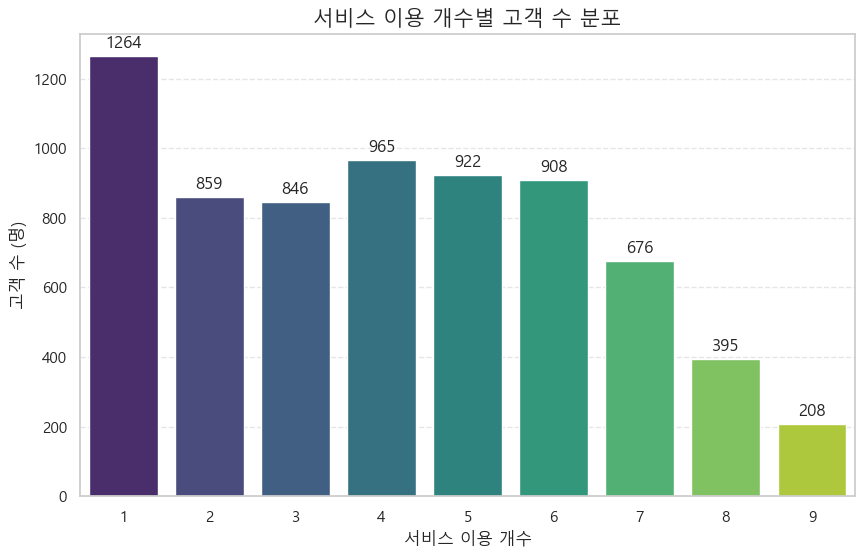

--- 서비스 개수별 비중 ---
ServiceCount
1    17.946898
2    12.196507
3    12.011927
4    13.701548
5    13.091012
6    12.892233
7     9.598183
8     5.608406
9     2.953287
Name: proportion, dtype: float64


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서비스 개수별 가입자 수 집계
service_counts = df['ServiceCount'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ServiceCount', data=df, palette='viridis')

# 막대 위에 가입자 수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('서비스 이용 개수별 고객 수 분포', fontsize=15)
plt.xlabel('서비스 이용 개수')
plt.ylabel('고객 수 (명)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 비율로도 확인
print("--- 서비스 개수별 비중 ---")
print(df['ServiceCount'].value_counts(normalize=True).sort_index() * 100)

* 서비스 가입 갯수가 적은 사람이 이탈을 더 많이함
* 가입기간이 작을수록 이탈이 쉬움
* 신규가입자의 월 요금이 낮을수록 이탈이 적음, 월 요금이 낮은 이유는 신규가입자 프로모션을 진행하고 있을 것으로 추정
* 장기 가입자면서 월요금이 높으면 이탈을 많이함
* 전자영수증을 신청한 사람이 이탈을 많이함 -> 전자거래에 익숙한사람
* electronic check : 계좌 번호 입력, 수동 결제가 더 많이 이탈함
* credit card(automatic), bank transter(automatic)이 자동결제수단이라 이탈이 적음
* 월간요금이 낮을수록 이탈이 낮음
* 고령자가 더 이탈이 많음, 왜냐면 고령자의 52%가 electronic check 결제 수단을 이용하고 있음
* electronic check 결제수단 이용자의 0.53%, mailed check이용자의 0.468%가 이탈함 이용이 불편해서 이탈을 하는 걸로 예측
* 가입기간, 계약기간이 짧을수록 이탈이 많음
* 서비스를 3개 이용하는 고객의 이탈율이 가장 높고 서비스 이용 갯수가 많아질수록 이탈율이 떨어짐
* 5년 이상 장기 고객은 서비스이용갯수가 3개 이상일 수록 이탈률이 높아지고 7개에서 가장 많이 이탈함
  

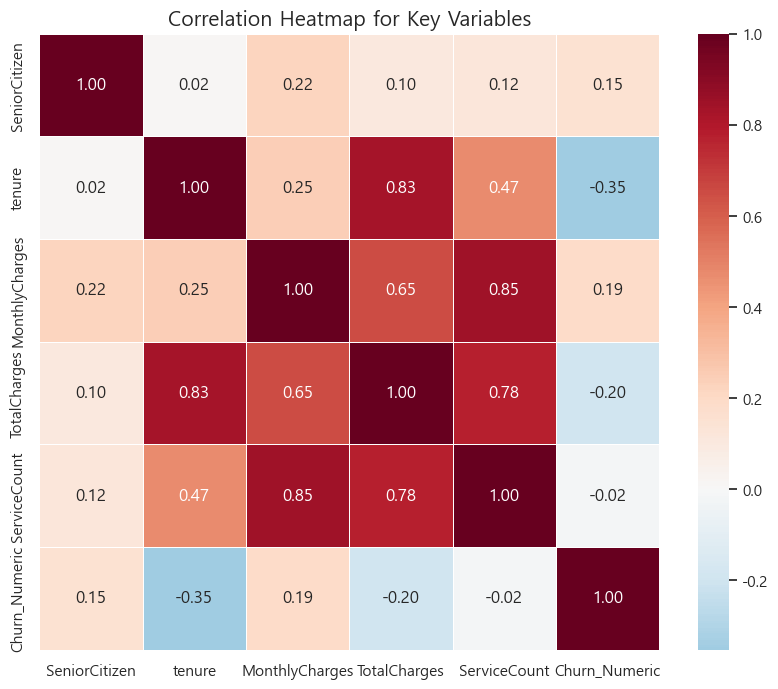

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 상관계수 계산을 위해 수치형 변수들만 선택
# 'TotalCharges'는 로드 시 문자열일 수 있으므로 다시 한번 숫자 변환
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 분석에 사용할 주요 수치형 및 인코딩된 변수 선택
cols_for_corr = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                 'ServiceCount', 'Churn_Numeric']

# 2. 상관계수 행렬 생성
corr_matrix = df[cols_for_corr].corr()

# 3. 히트맵 그리기
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # 상단 삼각형 가리기 (중복 제거)

sns.heatmap(corr_matrix, 
            annot=True,      # 수치 표시
            fmt=".2f",      # 소수점 둘째자리까지
            cmap='RdBu_r',  # 붉은색(양의 상관), 푸른색(음의 상관)
            center=0, 
            linewidths=0.5)

plt.title('Correlation Heatmap for Key Variables', fontsize=15)
plt.show()

# 데이터 분할
모델 학습 및 평가, 그리고 최종 submission 생성을 위해 데이터를 분할합니다.
제출 파일 생성을 위한 별도의 test 파일이 없으므로, 전체 데이터의 20%를 test set(hold-out)으로 분리하여 사용합니다.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")

# 5. 모델링 (Modeling with AutoGluon)
AutoGluon의 TabularPredictor를 사용하여 학습합니다.

In [ ]:
label = 'Churn'
save_path = 'ag_models_churn'

predictor = TabularPredictor(label=label, path=save_path).fit(
    train_data,
    presets='best_quality',  # 고품질 모델 학습 (시간이 더 걸림). 빠른 학습을 원하면 'medium_quality' 등 사용
    time_limit=60*5  # 예시: 최대 5분 학습 (필요에 따라 조절)
)

# 6. 앙상블 (Ensemble) 및 모델 비교 평가
AutoGluon은 `best_quality` 프리셋에서 자동으로 앙상블 모델(WeightedEnsemble)을 생성합니다.

In [ ]:
# 리더보드 확인
leaderboard = predictor.leaderboard(test_data)
display(leaderboard)

# 성능 평가
perf = predictor.evaluate(test_data)
print("Performance on Test Data:")
print(perf)

# 7. submission.csv 파일 생성
테스트 데이터(Hold-out set)에 대한 예측 결과를 저장합니다.

In [ ]:
# 예측 (확률 포함)
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)

# 결과 데이터프레임 생성
submission = pd.DataFrame({
    'Actual': test_data['Churn'],
    'Predicted': y_pred,
    'Probability_Yes': y_pred_proba.iloc[:, 1]  # 'Yes' 클래스 확률
})

# 파일 저장
submission.to_csv('submission_autogluon.csv', index=False)
print("submission_autogluon.csv file generated.")
display(submission.head())